In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

## Common NLP approaches
It turns out that there are several common types of features and approaches that form the "starting point" for NLP and text-based data problems.  

 - Bag of words
 - TF/IDF
 - n-grams
 - Stemming / part of speech tagging / etc.
 - Feature hashing

# NLP: Analyzing Review Text

Unstructured data makes up the vast majority of data.  This is a basic intro to handling unstructured data.  Our objective is to be able to extract the sentiment (positive or negative) from review text.  We will do this from Yelp review data.

The first build models, of increasing complexity, to predict the rating of a review from its text.  These models will be assessed based on the root mean squared error of the number of stars predicted.  


## Download and parse the data

Download the file from this AWS [link](https://s3.amazonaws.com/mmlc-data/yelp_train_academic_dataset_review.json.gz). This file is only a sample of the full data `yelp_train_academic_dataset_review.json`

In [3]:
import gzip
import ujson as json

with gzip.open('data/yelp_train_academic_dataset_review.json.gz') as f:
    data = [json.loads(line) for line in f]

In [4]:
print (data[0])
print (data[1])
print (data[2])
print (len(data))

{'review_id': '15SdjuK7DmYqUAj6rjGowg', 'date': '2007-05-17', 'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'votes': {'funny': 0, 'cool': 1, 'useful': 2}, 'user_id': 'Xqd0DzHaiyRqVH3WRG7hzg', 'stars': 5, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.", 'type': 'review'}
{'review_id': 'RF6UnRTtG7tWMcrO2GEoAg', 'date': '2010-03-22', 'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'votes': {'funny': 0, 'cool': 0, 'useful': 2}, 'user_id': 'H1kH6QZV7Le4zqTRNxoZow', 'stars': 2, 'text': "Unfortunately, the frustratio

Scikit Learn will want the labels in a separate data structure, so let's pull those out now.

In [5]:
stars = [row['stars'] for row in data]

## Building models

We will build and train an estimator to predict the star rating from the text of a review.  We will be using pipeline out of transformers and estimators provided by Scikit Learn.  You can decide whether these pipelines should take full review objects or just their text as input to the `fit()` and `predict()` methods, but it does pay to be consistent.


## Text vectorization using "bag of words"

Learning algorithms prefer vectors of numbers, not text.  The simplest way to turn a text into a vector of number is to treat the text as a "bag of words."  That is you:

  - Split the text into words
  - Count how many times each word (in some fixed vocabulary) occurs
  - _(Optionally)_ normalize the counts against some baseline
  - _(Variant)_ Just do a binary "yes / no" for whether each word (in some vocabulary) is contained in the material
  
The output is a very large, but usually sparse, vector: The number of coordinates is the number of words in our dictionary, and the $i$-th coordinate entry is the number of occurrences of the $i$-th word.

There's a reasonable implementation of this in the CountVectorizer class in sklearn.feature_extraction.text.  See http://scikit-learn.org/stable/modules/classes.html#text-feature-extraction-ref for more detail on the options.

For instance, here we'll apply this to each sentence (as a separate bag).

## bag_of_words_model

Build a linear model predicting the star rating based on the count of the words in each document (bag-of-words model).  Use a [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) or [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer) to produce a feature matrix giving the counts of each word in each review.  Feed this in to linear model, such as `Ridge` or `SGDRegressor`, to predict the number of stars from each review.

**Important points**:
1. Don't forget to use tokenization!  This is important for good performance but it is also the most expensive step.  Try vectorizing as a first initial step and then running grid-serach and cross-validation only on of this pre-processed data.  `CountVectorizer` has to memorize the mapping between words and the index to which it is assigned.  This is linear in the size of the vocabulary.  The `HashingVectorizer` does not have to remember this mapping and will lead to much smaller models.

 ```python
 from sklearn.feature_extraction.text import CountVectorizer

 text = [row['text'] for row in data]
 X = CountVectorizer().fit_transform(text)

 # Now, this can be run with many different parameters
 # without needing to retrain the vectorizer:
 model.fit(X, stars, hyperparameter=something)
 ```

2. Try choosing different values for `min_df` (minimum document frequency cutoff) and `max_df` in `CountVectorizer`.  Setting `min_df` to zero admits rare words which might only appear once in the entire corpus.  This is both prone to overfitting and makes your data unmanageably large.  Don't forget to use cross-validation or to select the right value.  Notice that `HashingVectorizer` doesn't support `min_df`  and `max_df`.  However, it's not hard to roll your own transformer that solves for these.

3. Try using [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) or [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).  If the memory footprint is too big, try switching to [Stochastic Gradient Descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor) You might find that even ordinary linear regression fails due to the data size.  Don't forget to use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to determine the regularization parameter!  How do the regularization parameter `alpha` and the values of `min_df` and `max_df` from `CountVectorizer` change the answer?

4. You will likely pick up several hyperparameters between the tokenization step and the regularization of the estimator.  While is is more strictly correct to do a grid search over all of them at once, this can take a long time. Quite often, doing a grid search over a single hyperparameter at a time can produce similar results.  Alternatively, the grid search may be done over a smaller subset of the data, as long as it is representative of the whole.

5. Finally, assemble a pipeline that will transform the data from records all the way to predictions.  This will allow you to submit its predict method to the grader for scoring.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import base

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_name):
        self.col_name = col_name  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # Since we only have one column to be selected
        
        X_trans=[row[self.col_name] for row in X]
        
        return X_trans

cst=ColumnSelectTransformer('text') # Create an object for a class

In [7]:
from sklearn.linear_model import SGDRegressor
import sklearn
print (sklearn.__version__)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Ref: http://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer


data_train, data_test, stars_train, stars_test = train_test_split(data,stars, test_size=0.3, random_state=13)

print (len(data_train), len(data_test),len(stars_train),len(stars_test))
#print X_vectorized.shape

# do a Grid search for the min_df and max_df

# Create a pipeline
bag_of_words_est = Pipeline([
    # Column selector (remember the ML project?)
    ('cst',cst),
    # Vectorizer
    ('countVectorizer',CountVectorizer()),
    # Frequency filter (if necessary)
    # Regressor
    ('regressor',SGDRegressor())
    
])

# set the parameters for grid-search: min_df and max_df

parameters={'countVectorizer__min_df':(0.01,0.05,0.1)} # countVectorizer__ is used to indicate the pipeline step

gridsearch_min_df = GridSearchCV(bag_of_words_est, parameters)
print ("Performing grid search...")
print ("pipeline:", [name for name, _ in bag_of_words_est.steps])
print ("parameters:")
gridsearch_min_df.fit(data_train,stars_train)

print (gridsearch_min_df.best_estimator_) 
print (gridsearch_min_df.best_params_)

0.18.2
709039 303874 709039 303874
Performing grid search...
pipeline: ['cst', 'countVectorizer', 'regressor']
parameters:
Pipeline(steps=[('cst', ColumnSelectTransformer(col_name='text')), ('countVectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.05,
        ngra..., penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False))])
{'countVectorizer__min_df': 0.05}


In [10]:
# Write the object to dill
import dill
dill.dump(gridsearch_min_df, open('gridsearch_min_df_estimator.dill', 'wb'))

In [18]:
from sklearn.metrics import mean_squared_error

def plot_rating(pred, ground_truth, n_samples=50):
    
    plt.figure(figsize=(10,6))
    plt.plot(pred[:n_samples], 'ro', linewidth=2)
    plt.plot(ground_truth[:n_samples], 'b*')
    plt.xlabel('Test data points (index)')
    plt.ylabel('Star ratings')
    plt.legend(['Predicted', 'Actual'])
    
    print ('Mean-square error for model is {0}'.format(mean_squared_error(pred, ground_truth)))
    
    return

gridsearch_min_df = dill.load(open('gridsearch_min_df_estimator.dill', 'rb'))

In [19]:
# See the mean-square error on the models
rating_prediction = gridsearch_min_df.predict(data_test)

Mean-square error for model is 1.113078377918823


/home/carnd/anaconda3/envs/yelp/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


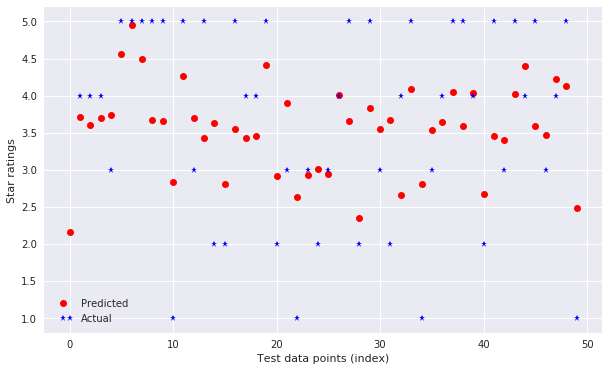

In [20]:
plot_rating(rating_prediction, stars_test)

Let's use `max_df`, and also restrict the words that appear in at least 1% of the documents.

In [22]:
bag_of_words_est = Pipeline([
    # Column selector (remember the ML project?)
    ('cst',cst),
    # Vectorizer
    ('countVectorizer',CountVectorizer(min_df=0.01)),
    # Frequency filter (if necessary)
    # Regressor
    ('regressor',SGDRegressor())
    
])


parameters={'countVectorizer__max_df':(0.5,0.75,1.0)} # countVectorizer__ is used to indicate the pipeline step

#bag_of_words_est = Pipeline([
    # Column selector (remember the ML project?)
    # Vectorizer
    # Frequency filter (if necessary)
    # Regressor
#])
#bag_of_words_est.fit(data, stars)
gridsearch_max_df= GridSearchCV(bag_of_words_est, parameters)
print("Performing grid search for max_df...")
print("pipeline:", [name for name, _ in bag_of_words_est.steps])
print("parameters:")
gridsearch_max_df.fit(data_train,stars_train)

print (gridsearch_max_df.best_estimator_)   
print (gridsearch_max_df.best_params_)

Performing grid search for max_df...
pipeline: ['cst', 'countVectorizer', 'regressor']
parameters:
Pipeline(steps=[('cst', ColumnSelectTransformer(col_name='text')), ('countVectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.01,
        ngra..., penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False))])
{'countVectorizer__max_df': 1.0}


In [24]:
# Write to dill object
dill.dump(gridsearch_max_df, open('gridsearch_max_df_estimator.dill', 'wb'))

In [27]:
gridsearch_max_df = dill.load(open('gridsearch_max_df_estimator.dill', 'rb'))

In [28]:
rating_prediction = gridsearch_max_df.predict(data_test)

Mean-square error for model is 0.9598087017945776


/home/carnd/anaconda3/envs/yelp/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


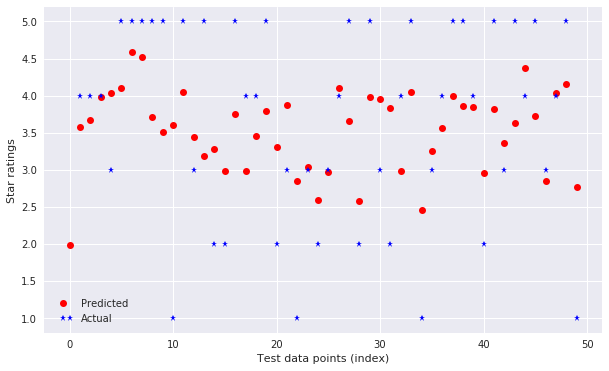

In [29]:
plot_rating(rating_prediction, stars_test)

### Modify few hyper-parameters

In [31]:
bag_of_words_est = Pipeline([
    # Column selector (remember the ML project?)
    ('cst',cst),
    # Vectorizer
    ('countVectorizer',CountVectorizer(min_df=0.01,max_df=0.5)),
    # Frequency filter (if necessary)
    # Regressor
    ('regressor',SGDRegressor())
    
])


parameters={'regressor__alpha':(0.00001,0.0001,0.001)} # regressor__ is used to indicate the pipeline step

gridsearch_alpha= GridSearchCV(bag_of_words_est, parameters)
print("Performing grid search for alpha (regularization)...")
print("pipeline:", [name for name, _ in bag_of_words_est.steps])
print("parameters:")
gridsearch_alpha.fit(data_train,stars_train)

print (gridsearch_alpha.best_estimator_)   
print (gridsearch_alpha.best_params_) 
dill.dump(gridsearch_alpha, open('gridsearch_alpha_estimator.dill', 'wb'))

Performing grid search for alpha (regularization)...
pipeline: ['cst', 'countVectorizer', 'regressor']
parameters:


KeyboardInterrupt: 

In [33]:
gridsearch_alpha = dill.load(open('gridsearch_alpha_estimator.dill', 'rb'))

Mean-square error for model is 0.9598087017945776


/home/carnd/anaconda3/envs/yelp/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


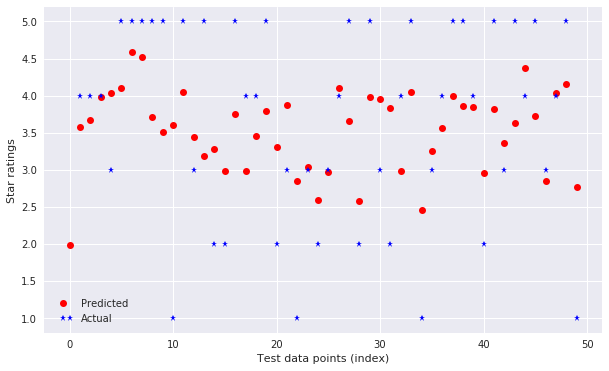

In [34]:
rating_predictions = gridsearch_alpha.predict(data_test)
plot_rating(rating_prediction, stars_test)

This is the goal of the __tf-idf weighting__.  A precise definition is:


  1. If $d$ denotes a document and $t$ denotes a term, then the _raw term frequency_ $\mathrm{tf}^{raw}(t,d)$ is
  $$ \mathrm{tf}^{raw}(t,d) = \text{the number of times the term $t$ occurs in the document $d$} $$
  The vector of all term frequencies can optionally be _normalized_ either by dividing by the maximum of any single word's occurrence count ($L^1$) or by the Euclidean length of the vector of word occurrence counts ($L^2$).  Scikit-learn by defaults does this second one:
  $$ \mathrm{tf}(t,d) = \mathrm{tf}^{L^2}(t,d) = \frac{\mathrm{tf}^{raw}(t,d)}{\sqrt{\sum_t \mathrm{tf}^{raw}(t,d)^2}} $$
  2. If $$ D = \left\{ d : d \in D \right\} $$ is the set of possible documents, then  the _inverse document frequency_ is
  $$ \mathrm{idf}^{naive}(t,D) = \log \frac{\# D}{\# \{d \in D : t \in d\}} \\
  = \log \frac{\text{count of all documents}}{\text{count of those documents containing the term $t$}} $$
  with a common variant being
  $$ \mathrm{idf}(t, D) = \log \frac{\# D}{1 + \# \{d \in D : t \in d\}} \\
   = \log \frac{\text{count of all documents}}{1 + \text{count of those documents containing the term $t$}} $$
  (This second one is the default in scikit-learn. Without this tweak we would omit the $1+$ in the denominator and have to worry about dividing by zero if $t$ is not found in any documents.)
  3. Finally, the weight that we assign to the term $t$ appearing in document $d$ and depending on the corpus of all documents $D$ is
  $$ \mathrm{tfidf}(t,d,D) = \mathrm{tf}(t,d) \mathrm{idf}(t,D) $$

## normalized_model
Normalization is key for good linear regression. Previously, we used the count as the normalization scheme.  By adding the normalization transformer to your pipeline to improves the model.  Try some of these:

1. You can use the "does this word present in this document" as a normalization scheme, which means the values are always 1 or 0.  So we give no additional weight to the presence of the word multiple times.

2. Try using the log of the number of counts (or more precisely, $log(x+1)$). This is often used because we want the repeated presence of a word to count for more but not have that effect tapper off.

3. [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a common normalization scheme used in text processing.  Use the [TFIDFTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer). There are options for using `idf` and taking the logarithm of `tf`.  Do these significantly affect the result?


In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

normalized_model = Pipeline([
    ('cst',cst),
    # Vectorizer
    ('countVectorizer',CountVectorizer(min_df=0.01,max_df=0.5)),
    # Frequency filter (if necessary)
    # TF-IDF
    ('tfidf', TfidfTransformer(sublinear_tf=True)), # keeping it True uses log(x+1)
    # Regressor
    ('regressor',SGDRegressor())
    
])

normalized_model.fit(data_train,stars_train)



Pipeline(steps=[('cst', ColumnSelectTransformer(col_name='text')), ('countVectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=0.01,
        ngra..., penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False))])

In [36]:
dill.dump(normalized_model, open('normalized_model.dill', 'wb'))

In [37]:
normalized_model = dill.load(open('normalized_model.dill', 'rb'))

In [38]:
rating_predictions = normalized_model.predict(data_test)

Mean-square error for model is 0.9598087017945776


/home/carnd/anaconda3/envs/yelp/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


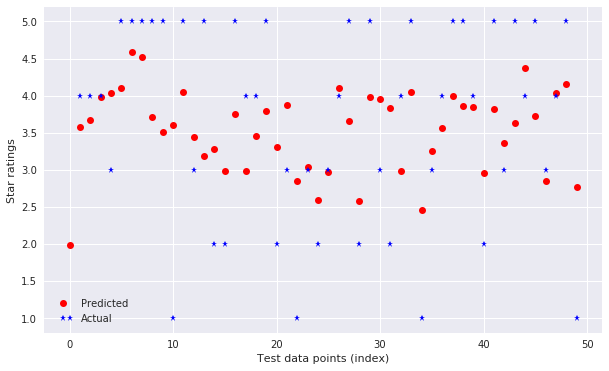

In [39]:
plot_rating(rating_prediction, stars_test)

## bigram_model
In a bigram model, we'll consider both single words and pairs of consecutive words that appear.  This is going to be a much higher dimensional problem (large $p$) so you should be careful about overfitting.

Sometimes, reducing the dimension can be useful.  Because we are dealing with a sparse matrix, we have to use [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD).  If we reduce the dimensions, we can use a more sophisticated models than linear ones.

As before, memory problems can crop up due to the engineering constraints. Playing with the number of features, using the `HashingVectorizer`, incorporating `min_df` and `max_df` limits, and handling stop-words in some way are all methods of addressing this issue. If you are using `CountVectorizer`, it is possible to run it with a fixed vocabulary (based on a training run, for instance). Check the documentation.

**A side note on multi-stage model evaluation:** When your model consists of a pipeline with several stages, it can be worthwhile to evaluate which parts of the pipeline have the greatest impact on the overall accuracy (or other metric) of the model. This allows you to focus your efforts on improving the important algorithms, and leaving the rest "good enough".

One way to accomplish this is through ceiling analysis, which can be useful when you have a training set with ground truth values at each stage. Let's say you're training a model to extract image captions from websites and return a list of names that were in the caption. Your overall accuracy at some point reaches 70%. You can try manually giving the model what you know are the correct image captions from the training set, and see how the accuracy improves (maybe up to 75%). Alternatively, giving the model the perfect name parsing for each caption increases accuracy to 90%. This indicates that the name parsing is a much more promising target for further work, and the caption extraction is a relatively smaller factor in the overall performance.

If you don't know the right answers at different stages of the pipeline, you can still evaluate how important different parts of the model are to its performance by changing or removing certain steps while keeping everything else constant. You might try this kind of analysis to determine how important adding stopwords and stemming to your NLP model actually is, and how that importance changes with parameters like the number of features.

In [42]:
from spacy.en import STOP_WORDS
print (STOP_WORDS)
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

data_train, data_test, stars_train, stars_test=train_test_split(data,stars,test_size=0.3,random_state=13)


bigram_model=Pipeline([
        ('cst',cst),
        ('countVect',CountVectorizer(min_df=0.01,max_df=0.5,ngram_range=(1,2),stop_words=STOP_WORDS)),
        ('tfidf', TfidfTransformer(sublinear_tf=True)), # keeping it True uses log(x+1)
        ('svd',TruncatedSVD()), # This is for dimensionality reduction
        ('regressor',SGDRegressor())
    ])

parameters={
    'svd__n_components':(2,3,5)
}
gridsearch_bigram = GridSearchCV(bigram_model, parameters)

print("Performing grid search for bigram...")
print("pipeline:", [name for name, _ in bigram_model.steps])
print("parameters:")
gridsearch_bigram.fit(data_train, stars_train)

print (gridsearch_bigram.best_estimator_)   
print (gridsearch_bigram.best_params_)

{'both', 'via', 'these', 'seeming', 'empty', 'among', 'thence', 'me', 're', 'anywhere', 'did', 'forty', 'other', 'six', 'ourselves', 'becoming', 'namely', 'everywhere', 'two', 'whereas', 'various', 'became', 'every', 'amongst', 'along', 'somehow', 'anything', 'am', 'one', 'five', 'made', 'so', 'give', 'its', 'least', 'moreover', 'were', 'are', 'although', 'only', 'out', 'never', 'before', 'well', 'beside', 'without', 'becomes', 'do', 'they', 'somewhere', 'nobody', 'upon', 'anyone', 'back', 'move', 'serious', 'against', 'used', 'beforehand', 'but', 'which', 'may', 'full', 'herself', 'there', 'during', 'and', 'through', 'about', 'less', 'over', 'them', 'just', 'until', 'where', 'mine', 'this', 'noone', 'you', 'might', 'any', 'thru', 'whenever', 'hers', 'a', 'often', 'again', 'still', 'whereupon', 'nowhere', 'thus', 'hereby', 'however', 'itself', 'everyone', 'former', 'either', 'yet', 'will', 'everything', 'even', 'another', 'bottom', 'himself', 'whereby', 'thereby', 'while', 'elsewhere',

In [43]:
dill.dump(gridsearch_bigram, open('gridsearch_bigram_estimator.dill', 'wb'))


In [44]:
rating_predictions = gridsearch_bigram.predict(data_test)

Mean-square error for model is 1.2731583384345544


/home/carnd/anaconda3/envs/yelp/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


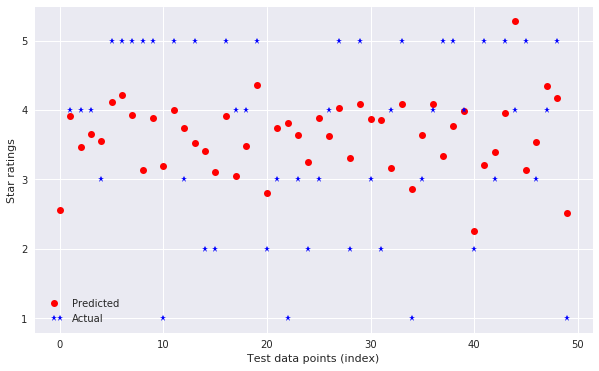

In [45]:
plot_rating(rating_predictions, stars_test)